In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import re
import string

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.shape

(7613, 5)

In [4]:
# only keeping text features

In [5]:
df = df.drop(['id','keyword','location'], axis=1)

In [6]:
duplicate_dict = {}
for num, row in df[df['text'].duplicated()].iterrows():
    if row['text'] not in duplicate_dict:
        duplicate_dict[row['text']] = [row['target']]
    else:
        duplicate_dict[row['text']].append(row['target'])
duplicate_dict

opp_target = []
for k,v in duplicate_dict.items():
    if all(x == v[0] for x in v):
        pass
    else:
        opp_target.append(k)
index_list = []
for i in opp_target:
    for j in list(df[df['text'].str.contains(i)].index.values):
        index_list.append(j)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [7]:
df.shape

(7613, 2)

In [8]:
df = df.drop(np.array(index_list), axis=0)
df.shape

(7580, 2)

In [9]:
df = df.drop_duplicates(subset = 'text', keep='first') # we remove 1 of each of the remaining duplicate pairs
df.shape

(7493, 2)

In [10]:
stop_words = stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [12]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,text,target
0,deeds reason earthquake may allah forgive -PRON-,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive wildfire evacuation order cal...,1
4,get send photo ruby alaska smoke wildfires pou...,1


### One-hot

In [13]:
max_words = df['text'].apply(lambda x: len(x.split())).max()
max_words

23

In [14]:
voc_size = 5000
sentence_length = max_words

In [15]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
corpus = list(df['text'])

In [17]:
onehot_repr = [one_hot(words, voc_size) for words in corpus]
onehot_repr

[[1113, 4600, 2491, 4518, 1262, 1116, 232],
 [4625, 2346, 4718, 1652, 1596, 3806, 150],
 [2164, 3632, 2874, 165, 1210, 3629, 4918, 2874, 165, 118, 2355],
 [4727, 3921, 1793, 4918, 118, 3552],
 [2476, 1247, 2681, 753, 764, 3200, 183, 4417, 230],
 [4464, 387, 3552, 390, 3625, 310, 582, 4909, 836, 2346, 841, 1793],
 [294, 3106, 3511, 2727, 1278, 4499, 1034, 1672, 662, 601, 1041, 620],
 [3232, 3714, 4131, 2346, 17],
 [3533, 541, 1643, 4918, 2497, 3613, 4930, 4740],
 [4038, 431, 4066, 620],
 [514, 4727, 3144, 4709, 3014, 1352],
 [3099,
  596,
  3897,
  2476,
  294,
  4469,
  2630,
  3663,
  1870,
  596,
  3897,
  4366,
  4191,
  4366,
  4191,
  3930,
  1034],
 [2727, 1034, 1330, 2987, 3897, 327, 232, 4908, 50, 3839],
 [294, 1392, 3482, 2627, 1392],
 [2030, 230, 2143, 1605, 3676, 2688, 3366],
 [586, 541, 2508],
 [147, 1467],
 [137, 337],
 [3676, 4200],
 [214],
 [2280],
 [3368, 946],
 [147, 3697],
 [1240, 327],
 [2200],
 [1023, 4488, 1082, 1619, 2788],
 [834, 4705, 2923],
 [147, 2450],
 [2528

In [18]:
embeded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sentence_length)
print(embeded_docs)

[[   0    0    0 ... 1262 1116  232]
 [   0    0    0 ... 1596 3806  150]
 [   0    0    0 ...  165  118 2355]
 ...
 [   0    0    0 ... 1205  567 4680]
 [   0    0    0 ...  377 2251 1699]
 [   0    0    0 ... 1793  296  567]]


### Splitting Data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(embeded_docs, df['target'], test_size=.1, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6743, 23), (750, 23), (6743,), (750,))

### Building RNN w/ LSTM

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
embedding_vector_features=40

model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sentence_length))
model.add(Dropout(.3))
model.add(LSTM(100))
model.add(Dropout(.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 23, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


### Training Model

In [22]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

history = model.fit(X_train,y_train, validation_split=.1, epochs=20, batch_size=32, callbacks=ES)

Epoch 1/20
190/190 [==============================] - 10s 14ms/step - loss: 0.5834 - accuracy: 0.6940 - val_loss: 0.4851 - val_accuracy: 0.7585
Epoch 2/20
190/190 [==============================] - 2s 11ms/step - loss: 0.3944 - accuracy: 0.8301 - val_loss: 0.5050 - val_accuracy: 0.7644
Epoch 3/20
190/190 [==============================] - 2s 11ms/step - loss: 0.3109 - accuracy: 0.8680 - val_loss: 0.5729 - val_accuracy: 0.7481
Epoch 4/20
190/190 [==============================] - 2s 11ms/step - loss: 0.2616 - accuracy: 0.8957 - val_loss: 0.6927 - val_accuracy: 0.7319
Epoch 5/20
190/190 [==============================] - 2s 11ms/step - loss: 0.2233 - accuracy: 0.9163 - val_loss: 0.7919 - val_accuracy: 0.7393
Epoch 6/20
190/190 [==============================] - 2s 11ms/step - loss: 0.1915 - accuracy: 0.9277 - val_loss: 0.7843 - val_accuracy: 0.7230


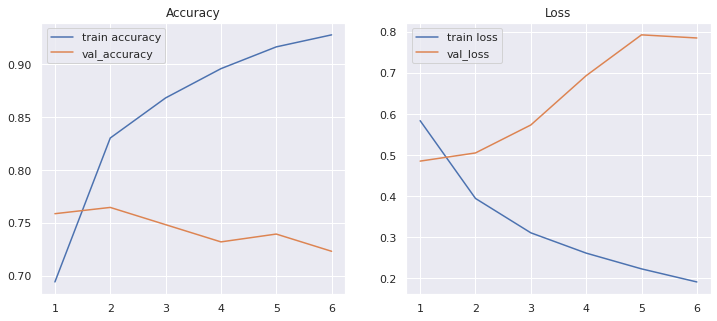

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['accuracy'], 
         label='train accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_accuracy'], 
         label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['loss'], 
         label='train loss')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_loss'], 
         label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()



### Evaluation

In [24]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 5ms/step - loss: 0.4824 - accuracy: 0.7867


[0.48237353563308716, 0.7866666913032532]

### RNN did poorly comparing to the simpler models.